In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras import layers, Sequential

import pandas as pd

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [2]:
img_size = 128
batch_size = 32

### Load the data

In [3]:
def load_data():
    df = pd.read_csv("data/HAM10000_metadata.csv")
    df["label"] = df["dx"].apply(lambda dx: "malignant" if dx in ["akiec", "bcc", "mel"] else "benign") 
    df["image_id"] = df["image_id"].apply(lambda id: f"{id}.jpg")
    df = df.sample(frac=1, random_state=0)
    
    training_df = df[:8000]
    validation_df = df[8000:9000]
    testing_df = df[9000:]
    
    training_data_generator = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.85, 1.15],
        zoom_range=[0.85, 1.15]
    )

    validation_data_generator = ImageDataGenerator(
        rescale=1.0/255
    )
    
    testing_data_generator = ImageDataGenerator(
        rescale=1.0/255
    )
    
    training_data = training_data_generator.flow_from_dataframe(
        dataframe= training_df,
        directory="data/images",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
        classes=["benign", "malignant"],
        shuffle=False
    )

    validation_data = validation_data_generator.flow_from_dataframe(
        dataframe=validation_df,
        directory="data/images",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
        classes=["benign", "malignant"],
        shuffle=False
    )

    test_data = testing_data_generator.flow_from_dataframe(
        dataframe=testing_df,
        directory="data/images",
        x_col="image_id",
        y_col="label",
        target_size=(img_size, img_size),
        class_mode="categorical",
        classes=["benign", "malignant"],
        batch_size=1015,
        shuffle=False
    )

    return training_data, validation_data, test_data


### Creating the model
Explanation of why the model looks like it does

In [4]:
def create_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

    # model =  Sequential()
    # model.add(layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding='valid', input_shape=(img_size, img_size, 3)))
    # model.add(layers.MaxPool2D((3, 3), strides=(2, 2), padding='valid'))
    # model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
    # model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))
    # model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    # model.add(layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    # model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(4096, activation='relu'))
    # model.add(layers.Dense(4096, activation='relu'))
    # model.add(layers.Dense(1, activation='sigmoid'))
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

### Training the model

In [5]:
def train_model(model, training_data, validation_data, epochs=2):
    history = model.fit(training_data, epochs=epochs, validation_data=validation_data, verbose=1, class_weight={"benign": 1.0, "malignant": 4.0})
    return history

### Evaluate the model

In [6]:
def evaluate_model(model, test_data):
    data_tuple = test_data[0]
    inputs = data_tuple[0]
    predicted = model.predict(inputs)
    ground_truth = [x[1] for x in data_tuple[1]]
    predictions = [x[1] for x in predicted]
    rounded_ground_truth = [round(x) for x in ground_truth]
    rounded_predictions = [round(x) for x in predictions]
    print("---- Ground truth ----")
    print(f"Min: {np.min(ground_truth)}")
    print(f"Max: {np.max(ground_truth)}")
    print(f"Mean: {np.mean(ground_truth)}")
    print(f"Mean rounded: {np.mean(rounded_ground_truth)}")
    print("---- Predictions ----")
    print(f"Min: {np.min(predictions)}")
    print(f"Max: {np.max(predictions)}")
    print(f"Mean: {np.mean(predictions)}")
    print(f"Mean rounded: {np.mean(rounded_predictions)}")
    return accuracy_score(rounded_ground_truth, rounded_predictions), f1_score(rounded_ground_truth, rounded_predictions)

Comments on the results

In [7]:
def save_model(model, path):
    model.save_weights(path)

### Putting it all together

In [8]:
model = create_model()
training_data, validation_data, test_data = load_data()
training_result = train_model(model, training_data, validation_data, epochs=600)
# save_model(model, "./models/temp_model_2")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1015 validated image filenames belonging to 2 classes.


2022-03-05 21:12:46.173222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-05 21:12:46.173341: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-05 21:12:46.566800: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-05 21:12:46.706675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/600
250/250 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.8003

2022-03-05 21:13:45.384824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 64s 255ms/step - loss: 0.5343 - accuracy: 0.8003 - val_loss: 0.4793 - val_accuracy: 0.7950
Epoch 2/600
250/250 [==============================] - 62s 248ms/step - loss: 0.4056 - accuracy: 0.8050 - val_loss: 0.4942 - val_accuracy: 0.7950
Epoch 3/600
250/250 [==============================] - 63s 251ms/step - loss: 0.4123 - accuracy: 0.8041 - val_loss: 0.4927 - val_accuracy: 0.7950
Epoch 4/600
250/250 [==============================] - 64s 254ms/step - loss: 0.4058 - accuracy: 0.8061 - val_loss: 0.5196 - val_accuracy: 0.7950
Epoch 5/600
250/250 [==============================] - 64s 254ms/step - loss: 0.4004 - accuracy: 0.8050 - val_loss: 0.4928 - val_accuracy: 0.7950
Epoch 6/600
250/250 [==============================] - 63s 250ms/step - loss: 0.3898 - accuracy: 0.8060 - val_loss: 0.5275 - val_accuracy: 0.7930
Epoch 7/600
250/250 [==============================] - 62s 249ms/step - loss: 0.3917 - accuracy: 0.8061 - val_loss: 0.5367 - val_accurac

In [8]:
model = create_model()
model.load_weights("./models/model_2")
training_data, validation_data, test_data = load_data()

2022-03-07 13:41:55.497698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-07 13:41:55.497815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1015 validated image filenames belonging to 2 classes.


In [10]:
# test_result = evaluate_model(model, test_data)
# print(f"Accuracy: {test_result[0]}")
# print(f"F1-score: {test_result[1]}")


2022-03-06 13:36:48.342110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


---- Ground truth ----
Min: 0.0
Max: 1.0
Mean: 0.18916256725788116
Mean rounded: 0.1891625615763547
---- Predictions ----
Min: 0.0
Max: 1.0
Mean: 0.16765457391738892
Mean rounded: 0.1477832512315271
Accuracy: 0.8266009852216749
F1-score: 0.48538011695906436


In [11]:
# print(training_result.history)

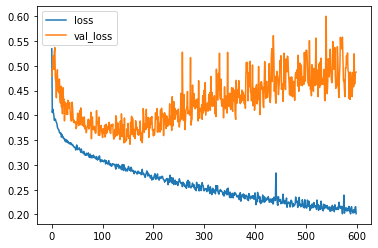

In [12]:
# labels = ["loss", "val_loss"]
# for label in labels:
#     plt.plot(training_result.history[label])
# plt.legend(labels)
# plt.show()

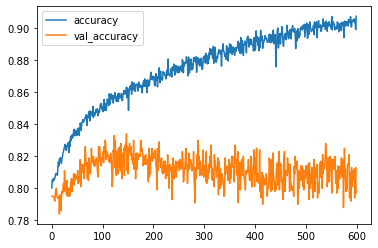

In [13]:
# labels = ["accuracy", "val_accuracy"]
# for label in labels:
#     plt.plot(training_result.history[label])
# plt.legend(labels)
# plt.show()

In [10]:
def plot_cm(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title(f'Title')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [11]:
data_tuple = test_data[0]
inputs = data_tuple[0]
predicted = model.predict(inputs)
ground_truth = [x[1] for x in data_tuple[1]]
predictions = [x[1] for x in predicted]
rounded_ground_truth = [round(x) for x in ground_truth]
rounded_predictions = [round(x) for x in predictions]

2022-03-07 13:45:20.999045: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-07 13:45:21.032564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Legitimate Transactions Detected (True Negatives):  756
Legitimate Transactions Incorrectly Detected (False Positives):  67
Fraudulent Transactions Missed (False Negatives):  109
Fraudulent Transactions Detected (True Positives):  83
Total Fraudulent Transactions:  192


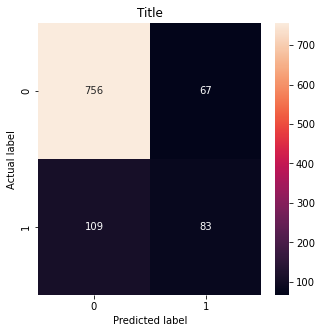

In [12]:
plot_cm(rounded_ground_truth, rounded_predictions)